# Assignment: Automatic Crack Segmentation Using Deep Learning


## Summary

This project implements a semantic segmentation pipeline for automatic crack detection using deep learning. The solution is based on a U-Net architecture implemented in PyTorch and trained on the DeepCrack dataset. The workflow includes data loading and preprocessing, model definition, training, quantitative evaluation using standard segmentation metrics (Accuracy, Jaccard(IoU), and F1-score), and qualitative visualization of predicted crack masks.

The goal of this project is to accurately identify crack regions at the pixel level, enabling reliable structural damage assessment through image-based inspection.

---

## Instructions

Follow the steps below to run the project successfully.

### 1. Install Dependencies

Ensure that Python (version 3.8 or higher) is installed.  
Navigate to the project directory and install the required packages:

```bash
pip install -r requirements.txt
```

It is recommended to use a virtual environment to avoid dependency conflicts.

---

### 2. Prepare the Dataset

Make sure the DeepCrack dataset is located in the working directory with the following structure:

```
train_img/
train_lab/
test_img/
test_lab/
```

Image and label files may have different extensions (e.g., `.jpg` and `.png`), which is handled automatically by the dataset loader.

---

### 3. Run the Code

Open the provided Jupyter Notebook and **run all cells sequentially**:

1. Dataset and model class definitions  
2. Data loading and preprocessing  
3. Model training  
4. Model evaluation  
5. Visualization of segmentation results  

Running all cells in order will train the model, evaluate its performance on the test set, and display example segmentation outputs.

---

### 4. Output

The notebook reports:
- Training loss per epoch
- Final evaluation metrics (Accuracy, Jaccard (IoU), F1-score)
- Visual comparisons between input images, ground-truth masks, and predicted crack segmentations


# Imports

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


# Configuration
(Fine tune to taste)

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 30
LR = 1e-4
VISUALIZE_SAMPLES = 10

# STEP 1: Class definition
This step defines the core classes used for data handling and model architecture.


## CrackDataset Class:
The `CrackDataset` class is a custom PyTorch dataset designed to load crack images and their corresponding ground-truth segmentation masks. Since image and label files in the DeepCrack dataset may have different file extensions (e.g., `.jpg` for images and `.png` for masks), image–mask pairs are matched using their filename stems (filenames without extensions).

Each dataset sample consists of:
- A 3-channel RGB image tensor
- A single-channel binary mask tensor, where crack pixels are labeled as 1 and background pixels as 0

Images and masks are resized to a fixed resolution and converted to tensors using a shared transformation pipeline to preserve pixel-wise alignment.


In [3]:
class CrackDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Build stem → filename maps
        self.img_files = {
            os.path.splitext(f)[0]: f
            for f in os.listdir(img_dir)
            if f.lower().endswith(('.jpg', '.png'))
        }

        self.mask_files = {
            os.path.splitext(f)[0]: f
            for f in os.listdir(mask_dir)
            if f.lower().endswith(('.jpg', '.png'))
        }

        # Keep only common stems
        self.common_keys = sorted(self.img_files.keys() & self.mask_files.keys())

        if len(self.common_keys) == 0:
            raise RuntimeError("No matching image–mask pairs found.")

    def __len__(self):
        return len(self.common_keys)

    def __getitem__(self, idx):
        key = self.common_keys[idx]

        img_path = os.path.join(self.img_dir, self.img_files[key])
        mask_path = os.path.join(self.mask_dir, self.mask_files[key])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()
        return image, mask


## DoubleConv Class:

The `DoubleConv` class implements a basic convolutional block used throughout the U-Net architecture. It consists of two consecutive convolutional layers, each followed by batch normalization and a ReLU activation function.

This structure enhances feature extraction, improves convergence stability, and preserves spatial resolution through the use of padded convolutions.


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


## UNet Class
The `UNet` class defines the semantic segmentation model used for crack detection. The architecture follows the standard U-Net design, composed of:

- An encoder path that progressively downsamples the input image to extract high-level features
- A bottleneck layer that captures abstract representations
- A decoder path that upsamples the feature maps back to the original resolution

Skip connections are used between corresponding encoder and decoder layers to retain fine spatial details, which is essential for detecting thin crack structures. The final layer outputs a single-channel probability map using a sigmoid activation function for binary segmentation.


In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.u3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.uconv3 = DoubleConv(512, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.uconv2 = DoubleConv(256, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.uconv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.pool(d1))
        d3 = self.d3(self.pool(d2))

        b = self.bottleneck(self.pool(d3))

        x = self.u3(b)
        x = self.uconv3(torch.cat([x, d3], dim=1))

        x = self.u2(x)
        x = self.uconv2(torch.cat([x, d2], dim=1))

        x = self.u1(x)
        x = self.uconv1(torch.cat([x, d1], dim=1))

        return torch.sigmoid(self.out(x))


# Step 2: Data Loading and Preprocessing

In this step, the DeepCrack dataset is prepared for training and evaluation. All images and masks are resized to a fixed resolution of 256 × 256 pixels and converted into PyTorch tensors. This ensures uniform input dimensions, which are required for batch-based training.

Separate dataset instances are created for the training and test sets, and PyTorch’s `DataLoader` is used to efficiently load mini-batches during training and sequential samples during evaluation.


In [6]:
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

train_dataset = CrackDataset(
    "train_img", "train_lab", transform=transform
)
test_dataset = CrackDataset(
    "test_img", "test_lab", transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)



# STEP 3: Train
The training phase focuses on optimizing the model parameters to accurately segment crack pixels from background pixels.

## Training Setup:
The U-Net model is moved to the available computation device (CPU or GPU). Binary Cross-Entropy (BCE) loss is used as the objective function, as the task is formulated as a binary segmentation problem. The Adam optimizer is employed to update the model parameters due to its adaptive learning rate capabilities.

In [7]:
model = UNet().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


## Training Loop:
The training loop iterates over multiple epochs. For each mini-batch:
1. Input images are passed through the model to obtain predictions
2. The loss between predictions and ground-truth masks is computed
3. Gradients are calculated via backpropagation
4. Model parameters are updated using the optimizer

The average training loss per epoch is reported to monitor convergence.

In [8]:
import matplotlib.pyplot as plt

epoch_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_epoch_loss:.4f}")

Epoch [1/30], Loss: 0.3431
Epoch [2/30], Loss: 0.2330
Epoch [3/30], Loss: 0.1958
Epoch [4/30], Loss: 0.1726
Epoch [5/30], Loss: 0.1467
Epoch [6/30], Loss: 0.1326
Epoch [7/30], Loss: 0.1198
Epoch [8/30], Loss: 0.1061
Epoch [9/30], Loss: 0.0963
Epoch [10/30], Loss: 0.0862
Epoch [11/30], Loss: 0.0807
Epoch [12/30], Loss: 0.0725
Epoch [13/30], Loss: 0.0687
Epoch [14/30], Loss: 0.0626
Epoch [15/30], Loss: 0.0589
Epoch [16/30], Loss: 0.0536
Epoch [17/30], Loss: 0.0523
Epoch [18/30], Loss: 0.0493
Epoch [19/30], Loss: 0.0457
Epoch [20/30], Loss: 0.0438
Epoch [21/30], Loss: 0.0419
Epoch [22/30], Loss: 0.0393
Epoch [23/30], Loss: 0.0371
Epoch [24/30], Loss: 0.0355
Epoch [25/30], Loss: 0.0358
Epoch [26/30], Loss: 0.0343
Epoch [27/30], Loss: 0.0313
Epoch [28/30], Loss: 0.0323
Epoch [29/30], Loss: 0.0337
Epoch [30/30], Loss: 0.0298


# STEP 4: Evaluation
After training, the model’s performance is quantitatively evaluated on the test dataset.

## Loss Function
We evaluate the shape of the loss function, to see if the model is learning properly

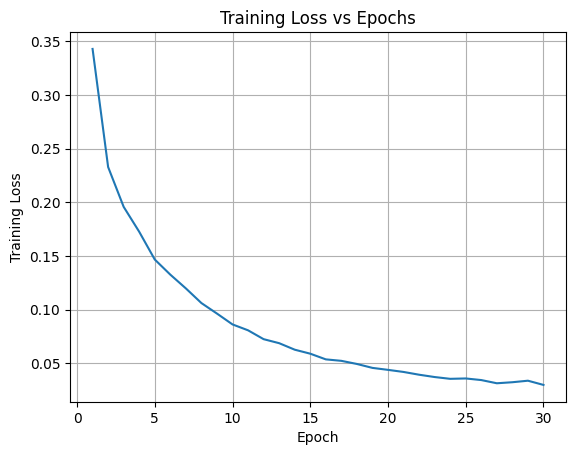

In [9]:
# Plot Loss vs Epochs
plt.figure()
plt.plot(range(1, EPOCHS + 1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()


We can see that the loss function has its typical shape and converges at almost 30 epochs, which means we are neither undertraining nor overfitting our model.

## Metrics Definition:
Three evaluation metrics are computed:
- **Accuracy**, measuring the proportion of correctly classified pixels
- **Jaccard Index (IoU)**, measuring the overlap between predicted and ground-truth crack regions
- **F1-score**, which balances precision and recall and is well suited for imbalanced segmentation tasks


In [10]:
def compute_metrics(pred, mask):
    pred = (pred > 0.5).float()

    tp = (pred * mask).sum()
    fp = (pred * (1 - mask)).sum()
    fn = ((1 - pred) * mask).sum()
    tn = ((1 - pred) * (1 - mask)).sum()

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    f1 = 2 * tp / (2 * tp + fp + fn + 1e-8)

    return accuracy.item(), iou.item(), f1.item()


## Running Evaluation:
The model is set to evaluation mode and gradients are disabled. Predictions are thresholded at 0.5 to obtain binary segmentation maps. Accuracy, Jaccard, and F1-score are computed for each test image, and the final performance is reported as the average over the entire test set.


In [11]:
model.eval()
accs, ious, f1s = [], [], []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)

        acc, iou, f1 = compute_metrics(preds, masks)
        accs.append(acc)
        ious.append(iou)
        f1s.append(f1)

print(f"Accuracy: {np.mean(accs):.4f}")
print(f"IoU: {np.mean(ious):.4f}")
print(f"F1-score: {np.mean(f1s):.4f}")


Accuracy: 0.9855
IoU: 0.7467
F1-score: 0.8417


# STEP 5: Visualization

Visualization is used to qualitatively assess segmentation performance.

## Visualization Definition
A visualization function is defined to display the original image, the ground-truth mask, and the predicted segmentation mask side by side for direct comparison.


In [12]:
def visualize(img, mask, pred):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img.permute(1,2,0))
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(pred.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.axis("off")

    plt.show()


## Visualization Execution
A sample from the test dataset is passed through the trained model, and the resulting prediction is visualized alongside the corresponding input image and ground-truth mask. This qualitative inspection helps identify correct detections, missed cracks, and false positives.

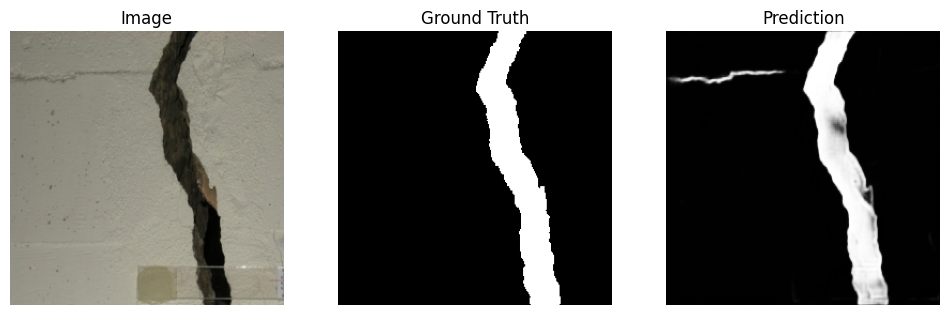

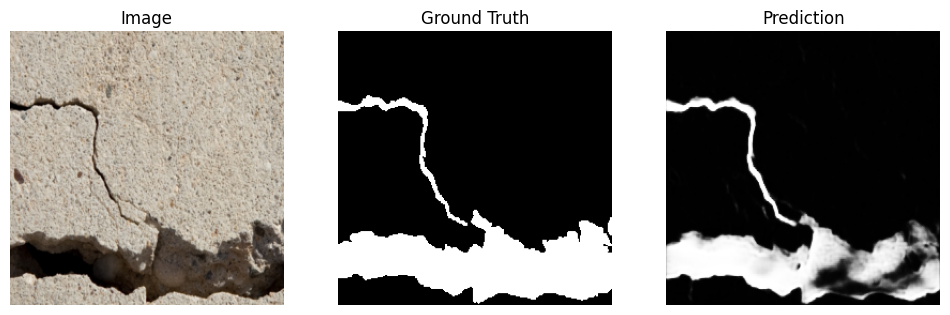

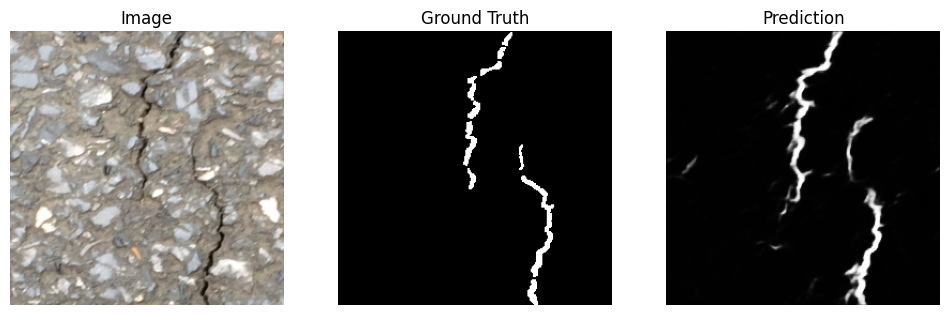

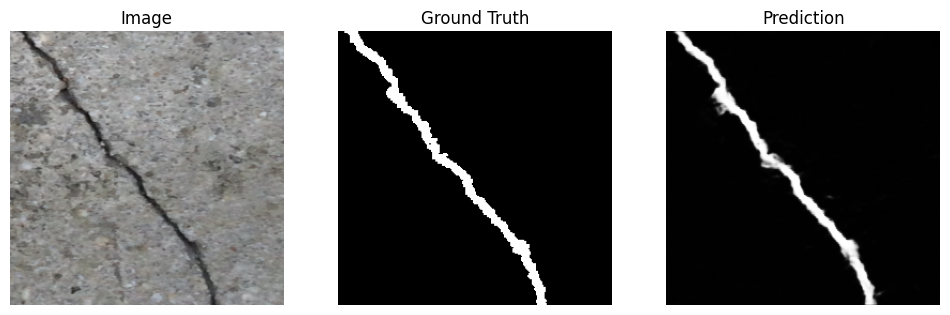

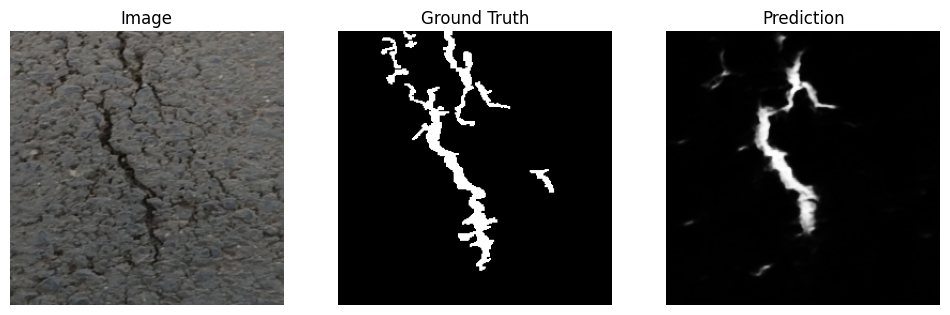

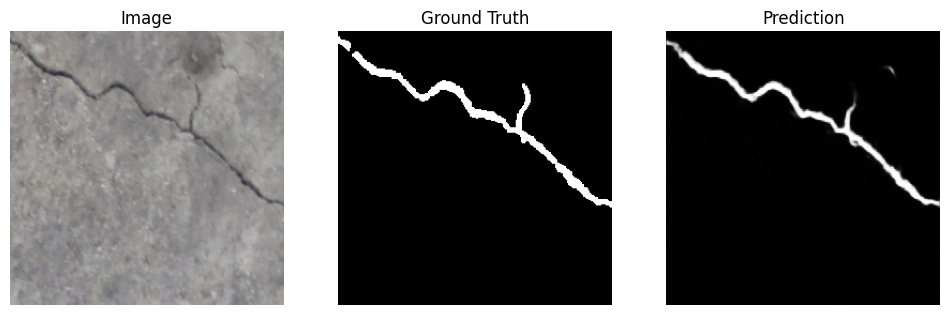

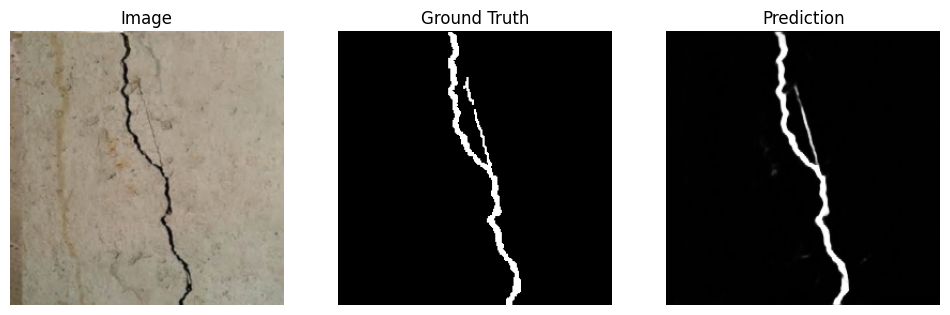

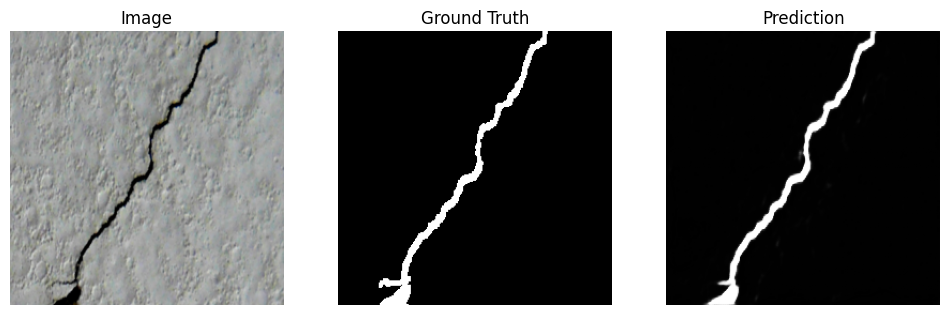

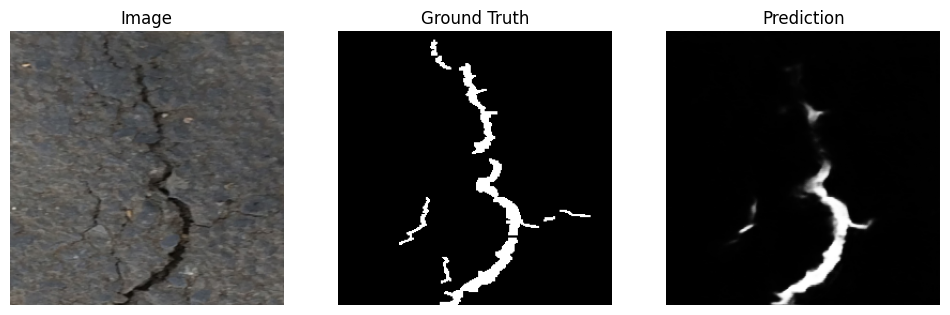

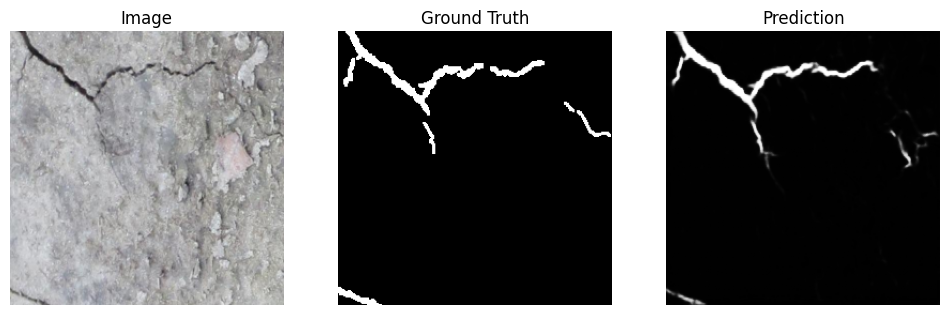

In [13]:

# Number of random samples to visualize

total_samples = len(test_dataset)

# Randomly select indices
random_indices = random.sample(range(total_samples), VISUALIZE_SAMPLES)

for idx in random_indices:
    # Get the sample from the dataset
    img, mask = test_dataset[idx]
    
    # Add batch dimension and move to device
    img_batch = img.unsqueeze(0).to(DEVICE)
    
    # Model prediction
    pred = model(img_batch).cpu()[0]
    
    # Visualize
    visualize(img, mask, pred)


## Store predicted images
Store all the predicted images to avoid recomputing and wasting computational power

In [14]:
os.makedirs("pred_masks", exist_ok=True)

model.eval()
with torch.no_grad():
    for idx, (img, _) in enumerate(test_dataset):
        # Add batch dimension
        img_batch = img.unsqueeze(0).to(DEVICE)
        
        # Predict
        pred = model(img_batch).cpu()[0].squeeze()
        
        # Convert to 0-255 for saving, preserving probabilities
        pred_img = (pred.numpy() * 255).astype(np.uint8)
        
        # Save as PNG
        Image.fromarray(pred_img).save(f"pred_masks/pred_{idx:03d}.png")
